In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv')
data

/var/folders/wc/rqgqs2ld2v9_r289z6535cx80000gn/T/ipykernel_30228/4212285927.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [3]:
from sklearn.model_selection import train_test_split

X, Y = data.loc[:, ['long', 'lat']], data.loc[:, ['level']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [5]:
from sklearn.model_selection import cross_val_score

def xgb_evaluate(max_depth, 
                 learning_rate, 
                 n_estimators, 
                 subsample, 
                 colsample_bytree):
    
    params = {'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'n_estimators': int(n_estimators),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'objective': 'multi:softmax'}
    
    xgb_model = xgb.XGBClassifier(**params)

    cv_score = np.mean(cross_val_score(xgb_model, 
                                       X_train, 
                                       Y_train, 
                                       cv=5, 
                                       scoring='accuracy'))
    return cv_score

optimizer = BayesianOptimization(f=xgb_evaluate,
                                 pbounds={'max_depth': (3, 10),
                                          'learning_rate': (0.001, 0.3),
                                          'n_estimators': (50, 300),
                                          'subsample': (0.7, 1.0),
                                          'colsample_bytree': (0.7, 1.0)},
                                 random_state=100)

optimizer.maximize(init_points=15, n_iter=25)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.5561    | 0.863     | 0.08423   | 5.972     | 261.2     | 0.7014    |
| 2         | 0.5568    | 0.7365    | 0.2016    | 8.781     | 84.18     | 0.8725    |
| 3         | 0.5449    | 0.9674    | 0.06355   | 4.297     | 77.09     | 0.7659    |
| 4         | 0.5562    | 0.9936    | 0.2437    | 4.204     | 254.1     | 0.7822    |
| 5         | 0.5554    | 0.8295    | 0.2821    | 8.724     | 134.0     | 0.7526    |
| 6         | 0.5431    | 0.8118    | 0.002701  | 4.767     | 248.9     | 0.7046    |
| 7         | 0.5561    | 0.8797    | 0.1815    | 3.736     | 145.5     | 0.7109    |
| 8         | 0.5589    | 0.9671    | 0.2943    | 3.42      | 272.6     | 0.8731    |
| 9         | 0.5627    | 0.9227    | 0.1894    | 7.073     | 55.11     | 0.763     |
| 10        | 0.5617    | 0.8634    | 0.231     | 4.75

In [6]:
params_optimal = optimizer.max['params']
params_optimal['max_depth'] = int(params_optimal['max_depth'])
params_optimal['n_estimators'] = int(params_optimal['n_estimators'])

xgb_optimal_model = xgb.XGBClassifier(**params_optimal)
xgb_optimal_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7648812874971804, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14188486034213257,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=270, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
predictions = xgb_optimal_model.predict(X_test)

Accuracy: 0.5491
              precision    recall  f1-score   support

           0       0.46      0.10      0.16       214
           1       0.40      0.17      0.24       540
           2       0.62      0.14      0.23        72
           3       0.57      0.89      0.70       966

    accuracy                           0.55      1792
   macro avg       0.51      0.32      0.33      1792
weighted avg       0.51      0.55      0.48      1792

Confusion Matrix:
[[ 21  29   1 163]
 [ 11  91   5 433]
 [  3  15  10  44]
 [ 11  93   0 862]]


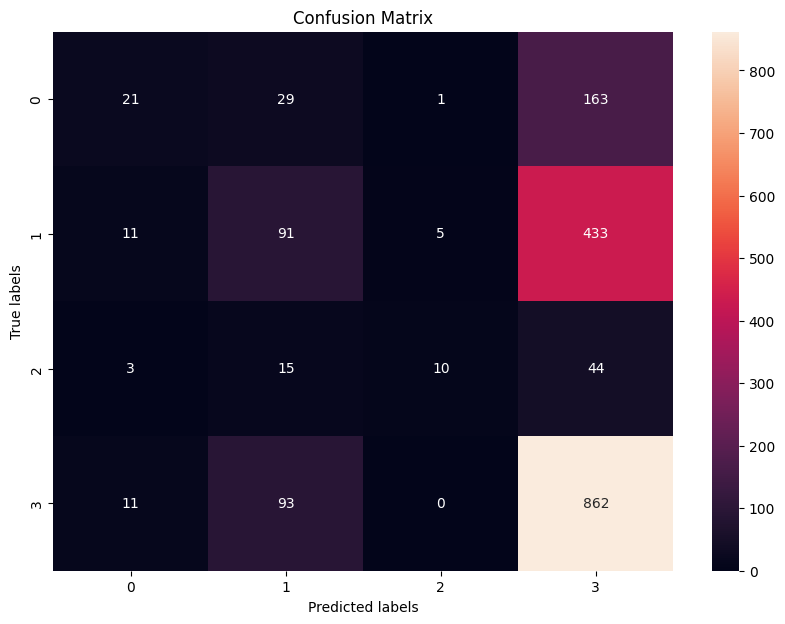

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(Y_test, predictions))

# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can visualize the confusion matrix using seaborn or matplotlib for better interpretation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_level = mean_squared_error(Y_test.iloc[:, 0], predictions)
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(Y_test.iloc[:, 0], predictions)

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))

Crime Level - MSE: 2.1150, RMSE: 1.4543, MAE: 0.9408
